#### FIO-ESM-2-0 --- Btr, Atlantic shift

In [1]:
import os
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cftime
%matplotlib inline

In [2]:
# Determine starting file and position:
def startFile(nn,Files):
    ff = 0
    nf = len(Files)
    dims = jc.getDims(Files[ff],'time')
    nm = dims[0].size
    while nn >= nm:
        nn = nn - nm
        ff = ff + 1
        if ff == nf:
            print('all files are computed')
            nn = 0
        else:
            dims = jc.getDims(Files[ff],'time')
            nm = dims[0].size
            
    return ff, nn

In [3]:
# Define which CMIP model, experiment and ensemble member you are using:
model = Clist['FIO-ESM-2-0']
EXP   = 'historical'
ENS   = 'r1i1p1f1'

In [4]:
# List all files to read in:
VFiles = model.getFiles('vo',    EXP=EXP,ENS=ENS,vtype='Omon',gtype='gn')
TFiles = model.getFiles('thetao',EXP=EXP,ENS=ENS,vtype='Omon',gtype='gn')
SFiles = model.getFiles('so',    EXP=EXP,ENS=ENS,vtype='Omon',gtype='gn')
WFiles = model.getFiles('tauuo', EXP=EXP,ENS=ENS,vtype='Omon',gtype='gn')

In [5]:
# Find coordinates to read data in from (read in data from velocity file):

ncid = Dataset(VFiles[0],'r')
if model.Oreg:
    lon  = ncid.variables[model.Olon][:]
    lat  = ncid.variables[model.Olat][:]
    lon,lat = np.meshgrid(lon,lat)
else:
    lon  = ncid.variables[model.Olon][:,:]
    lat  = ncid.variables[model.Olat][:,:]
lev  = ncid.variables['lev'][:]
ncid.close()

# Check if there is anything that needs changing in this model:
print('OextraT  ' + str(model.OextraT))
print('Ogrid    ' + str(model.Ogrid))
print('OextraWE ' + str(model.OextraWE))
print('OflipNS  ' + str(model.OflipNS))

OextraT  False
Ogrid    Btr
OextraWE [0, 0]
OflipNS  False


In [6]:
# Read in grid information:
mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
ncid = Dataset(mesh_mask,'r')
vmask = np.squeeze(ncid.variables['vmask'][:,:,:,:])
ncid.close()

In [7]:
# Find index of latitude closest to 26.5N (globally):
alat = 26.5
# Average latitudes over all longitudes:
mlat = np.mean(lat,axis=1)
# Find index closest 
ilat = np.argmin(np.abs(mlat-alat))  #some models might give 2 points, when 26.5 is in the middle of two points
print(ilat)

268


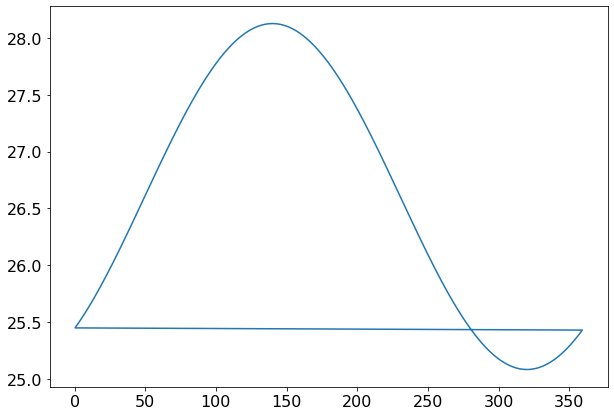

In [8]:
# Look at choice of latitude:
fig   = plt.figure(figsize=(10,7))
plt.plot(lon[ilat,:],lat[ilat,:])
plt.tick_params(labelsize=16)

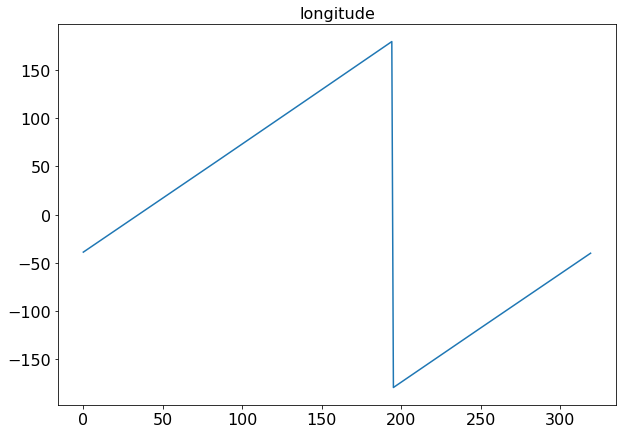

In [9]:
# Make longitudes between -180 and 180:
lon[np.where(lon>180)] = lon[np.where(lon>180)] - 360

fig   = plt.figure(figsize=(10,7))
plt.plot(lon[ilat,:])
plt.title('longitude',fontsize=16)
plt.tick_params(labelsize=16)

In [10]:
# Find maximum and minimum longitude:
alon_min = -80
alon_max = -10

ilon_min = np.argmin(np.abs(lon[ilat,:]-alon_min))
ilon_max = np.argmin(np.abs(lon[ilat,:]-alon_max))

In [11]:
#Change mask so that Atlantic is in the middle
print(np.shape(lon))
print(np.shape(lat))

vmask[:,:,:] = np.roll(vmask[:,:,:],90,axis=2)

ilon_min = ilon_min + 90
ilon_max = ilon_max + 90

#Make sure the min and max fall within the mask longitudes
if ilon_min > len(lon[0,:]):
    ilon_min = ilon_min - len(lon[0,:])
elif ilon_min < 0:
        ilon_min = len(lon[0,:]) + ilon_min
    
if ilon_max > len(lon[0,:]):
    ilon_max = ilon_max - len(lon[0,:])
elif ilon_max < 0:
        ilon_max = len(lon[0,:]) + ilon_max       

#Make sure ilat and ilon cross Florida
ilat = ilat + 3
ilon_min = ilon_min - 1

print(ilon_min,ilon_max,ilat)

(384, 320)
(384, 320)
52 116 271


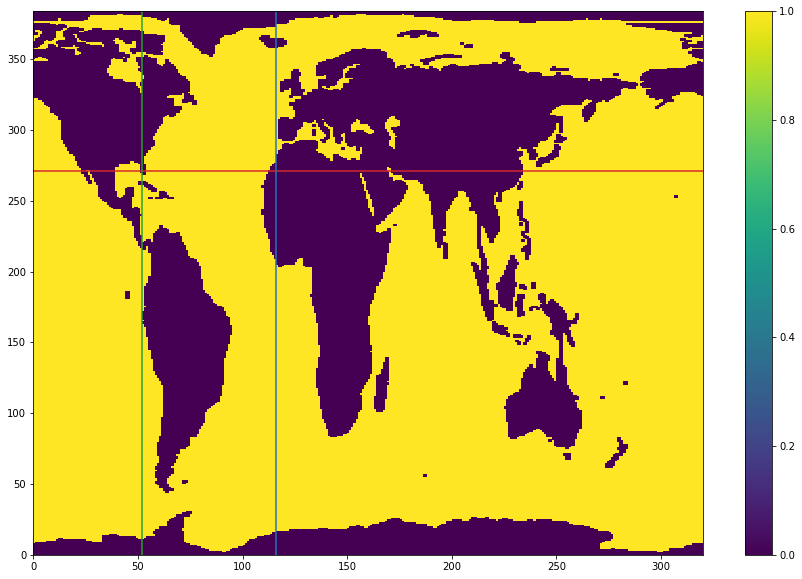

In [12]:
fig   = plt.figure(figsize=(15,10))
plt.pcolormesh(vmask[0,:,:])
plt.colorbar()
plt.axhline(y=ilat,color='C3')
plt.axvline(x=ilon_min,color='C2')
plt.axvline(x=ilon_max,color='C0')

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


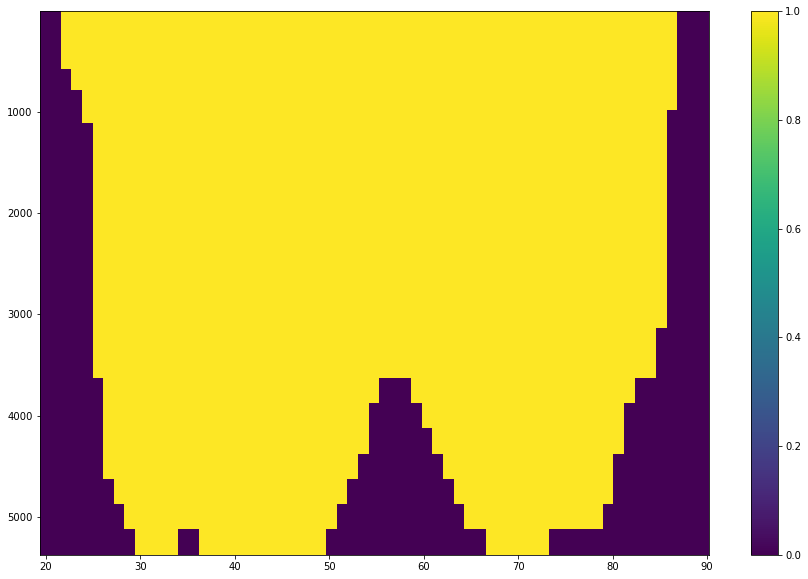

In [13]:
# View mask of choosen section:
fig   = plt.figure(figsize=(15,10))
plt.pcolormesh(lon[ilat,ilon_min:ilon_max],lev,vmask[:,ilat,ilon_min:ilon_max])
plt.colorbar()
# Invert y-axis:
plt.gca().invert_yaxis()

In [14]:
# Read in non-time-varying information:
ncid   = Dataset(VFiles[0],'r')
lev    = ncid.variables['lev'][:]
cal    = ncid.variables['time'].calendar
units  = ncid.variables['time'].units
bounds = ncid.variables['time'].bounds
ncid.close()

# Note that my mesh mask files have OextraWE already removed!
ncid = Dataset(mesh_mask,'r')
dx1  = np.roll(ncid.variables['dxv'][:,:],90,axis=-1)
dz1  = np.roll(ncid.variables['dzv'][:,:,:],90,axis=-1)
dx   = dx1[ilat,ilon_min:ilon_max]
dz   = dz1[:,ilat,ilon_min:ilon_max]
ncid.close()

In [15]:
# Setup file to store section data in (if it doesn't exist):

outfile = ('/home/users/jordi/section26data/' + model.name + '_' + EXP + '_' + ENS + '.nc')

print(outfile)

if not os.path.isfile(outfile):
    ncid = Dataset(outfile,'w')
    # Define dimentions:
    ncid.createDimension('lon',  ilon_max-ilon_min)
    ncid.createDimension('lat',  1)
    ncid.createDimension('lev',  len(lev))
    ncid.createDimension('time', None) 
    ncid.createDimension(bounds, 2)
    ncid.createDimension('ilat', 1)            

    # Define variables:
    ncid.createVariable('lon',     'f8', ('lat','lon',))
    ncid.createVariable('lat',     'f8', ('lat','lon',))
    ncid.createVariable('ilat',    'f8', ('ilat',))
    ncid.createVariable('lev',     'f8', ('lev',))
    ncid.createVariable('time',    'f8', ('time',))
    ncid.createVariable(bounds,    'f8', ('time',bounds,))
    ncid.createVariable('dx',      'f8', ('lat','lon',))
    ncid.createVariable('dz',      'f8', ('lev','lat','lon',))   # Might want to include time axis
    ncid.createVariable('vmask',   'f8', ('lev','lat','lon',))
    ncid.createVariable('vo',      'f8', ('time','lev','lat','lon',))
    ncid.createVariable('so',      'f8', ('time','lev','lat','lon',))
    ncid.createVariable('thetao',  'f8', ('time','lev','lat','lon',))
    ncid.createVariable('tauuo',   'f8', ('time','lat','lon',))   #No depth dimension
    
    # Fill in non-time varying variables:
    ncid.variables['time'].calendar = cal
    ncid.variables['time'].units    = units
    ncid.variables['time'].bounds   = bounds
    ncid.variables['lon'].units     = 'degrees_east'
    ncid.variables['lon'][:,:]      = lon[ilat,ilon_min:ilon_max]
    ncid.variables['lat'].units     = 'degrees_north'
    ncid.variables['lat'][:,:]      = lat[ilat,ilon_min:ilon_max]
    ncid.variables['ilat'][:]       = ilat
    ncid.variables['lev'][:]        = lev
    ncid.variables['vmask'][:,:,:]  = vmask[:,ilat,ilon_min:ilon_max]
    ncid.variables['dx'][:,:]       = dx
    ncid.variables['dz'][:,:,:]     = dz
    
    # Close file after creating:
    ncid.close()
    
    # Set month counter to 0:
    nn = 0
else:
    # Find out how much has been computed:
    ncid = Dataset(outfile,'r')
    time = ncid.variables['time'][:]
    ncid.close()
    
    nn = len(time)

/home/users/jordi/section26data/FIO-ESM-2-0_historical_r1i1p1f1.nc


In [16]:
# Loop through each uncomputed month:
nm = nn
nm = nm + (1980-900)     #Make sure FIO files start at 1940, since TFiles starts at this time
# Loop through each velocity file:
nf = len(VFiles)

for ff in range(0,nf):
    print(('computing file ' + str(ff+1) + ' of ' + str(nf)))
    
    # Determine how many months of data are in the current file:
    dims = jc.getDims(VFiles[ff],'vo')
    nt = dims[0].size
    
    # Determine which months have been computed:
    if nm >= nt:
        # All months from this file have been computed, move on to next file:
        nm = nm - nt
    else:
        # Loop through and compute all the missing months:
        for mm in range(nm,nt):  # mm is month in the file
                        
            # Read in velocity & time:
            ncid  = Dataset(VFiles[ff],'r')
            vo1   = np.roll(ncid.variables['vo'][mm,:,ilat,:],90,axis=-1)   #reads variable vo from VFiles with specific[time,lev,lat,lon]
            vo    = vo1[:,ilon_min:ilon_max]
            tt    = ncid.variables['time'][mm]
            tb    = ncid.variables[bounds][mm,:]
            # Get Calendar information:
            units2 = ncid.variables['time'].units
            ncid.close()
            
            # Read in temperature:
            nfile, ntime = startFile(nn,TFiles) #Get indices, TFiles already starts at 1940
            ncid = Dataset(TFiles[nfile],'r')   #nfile instead of ff and ntime instead of mm
            # Obtain square of T values:
            thetao11 = np.roll(ncid.variables['thetao'][ntime,:,ilat,:],90,axis=-1)   #reads variable thetao with shape (50,70) = (depth,lon)
            thetao1  = thetao11[:,ilon_min:ilon_max]
            thetao21 = np.roll(ncid.variables['thetao'][ntime,:,ilat+1,:],90,axis=-1)    #needed since thetao1 is a slice with 1 lat
            thetao2  = thetao21[:,ilon_min:ilon_max]
            thetao3  = np.roll(thetao1,-1,axis=1)    #lower right gridpoint
            thetao4  = np.roll(thetao2,-1,axis=1)    #upper right gridpoint
            
            # Calculate average of square T, so that T and u point overlap:
            thetao = np.zeros(np.shape(thetao1))
            for i in range (len(lev)):
                for j in range (ilon_max-ilon_min):
                    thetao[i,j] = ((thetao1[i,j]) + (thetao2[i,j]) + (thetao3[i,j]) + (thetao4[i,j]))/4
                    
            ncid.close()
                           
            # Read in salinity:
            nfile, ntime = startFile(nn+(1980-900),SFiles) # Get indices, start at 1940
            ncid = Dataset(SFiles[nfile],'r') #nfile instead of ff and ntime instead of mm
            # Obtain square of T values:
            so11 = np.roll(ncid.variables['so'][ntime,:,ilat,:],90,axis=-1)   #reads variable so with shape (50,70) = (depth,lon)
            so1 = so11[:,ilon_min:ilon_max]
            so21 = np.roll(ncid.variables['so'][ntime,:,ilat+1,:],90,axis=-1)    #needed since so1 is a slice with 1 lat
            so2 = so21[:,ilon_min:ilon_max]
            so3 = np.roll(so1,-1,axis=1)    #lower right gridpoint
            so4 = np.roll(so2,-1,axis=1)    #upper right gridpoint
            
            # Calculate average of square T, so that T and u point overlap:
            so = np.zeros(np.shape(so1))
            for i in range (len(lev)):
                for j in range (ilon_max-ilon_min):
                    so[i,j] = ((so1[i,j]) + (so2[i,j]) + (so3[i,j]) + (so4[i,j]))/4
                    
            ncid.close()
            
            # Read in wind stress: (same gridpoint as vo)
            nfile, ntime = startFile(nn+(1980-900),WFiles) # Get indices, start at 1940
            ncid  = Dataset(WFiles[nfile],'r') #nfile instead of ff and ntime instead of mm
            tauuo1 = np.roll(ncid.variables['tauuo'][ntime,ilat,:],90,axis=-1)   #reads variable tauuo from WFiles with specific[time,lev,lat,lon]
            tauuo = tauuo1[ilon_min:ilon_max]                 
            ncid.close()
            
            # Make sure time variable is the same:
            tt,tb = jc.fixTime(units,units2,cal,tt,tb)
            
            # Write to file:
            ncid = Dataset(outfile,'a')
            ncid.variables['vo'][nn,:,:,:] = vo
            ncid.variables['time'][nn] = tt
            ncid.variables[bounds][nn,:] = tb
            ncid.variables['thetao'][nn,:,:,:] = thetao
            ncid.variables['so'][nn,:,:,:] = so
            ncid.variables['tauuo'][nn,:,:] = tauuo
            ncid.close()
            
            nn = nn + 1
        nm = 0
print('Done!')

computing file 1 of 17
computing file 2 of 17
computing file 3 of 17
computing file 4 of 17
computing file 5 of 17
computing file 6 of 17
computing file 7 of 17
computing file 8 of 17
computing file 9 of 17
computing file 10 of 17


/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Warning: converting a masked element to nan.
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Warning: converting a masked element to nan.


computing file 11 of 17
computing file 12 of 17
computing file 13 of 17
computing file 14 of 17
computing file 15 of 17
computing file 16 of 17
computing file 17 of 17
Done!
